In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score 


In [37]:
import warnings
warnings.simplefilter(action='ignore')

In [39]:
train = pd.read_csv("/Users/sohoon/Desktop/STUDY/kaggle/bank_customer_churn/Churn_Modelling.csv")

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


## Understanding Data

In [41]:
train.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [42]:
train.CustomerId.unique()
train = train.dropna()
train = train.drop(columns=["CustomerId",'RowNumber','Surname'])
train = train.drop_duplicates()

In [43]:
categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
print(categorical_columns)
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary','Exited']
print(numerical_columns)

['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


Removing outliers using Z-score on each column

In [47]:
train = train[(np.abs(stats.zscore(train[numerical_columns])) < 3).all(axis=1)]
print(train.shape)

(9665, 11)


# EDA

Correlations

In [52]:
train_corr = train.copy()
train_corr.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

processing categorical columns

In [53]:
label_encoder = LabelEncoder()
for col in ['Geography', 'Gender']:
    train_corr[col] = label_encoder.fit_transform(train_corr[col])

<AxesSubplot:>

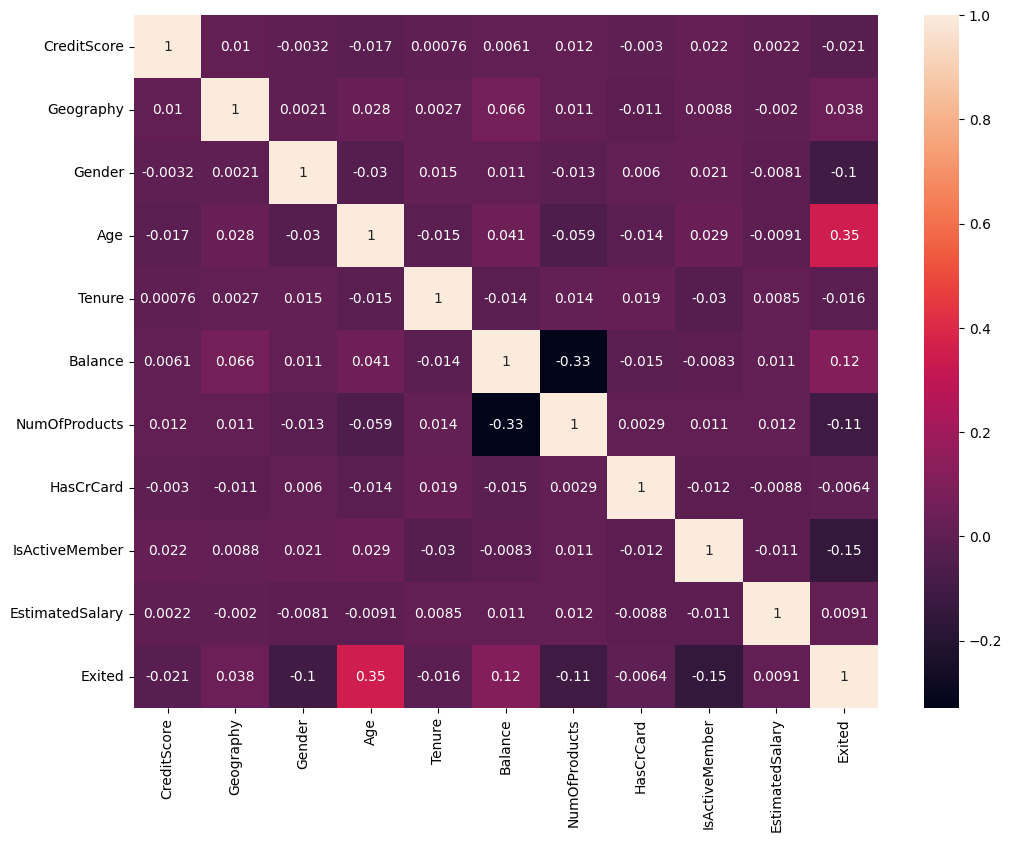

In [54]:
train_corr = train_corr.corr()
plt.figure(figsize=(12,9))
sns.heatmap(data=train_corr,annot=True)

Count number of categorical and numerical columns

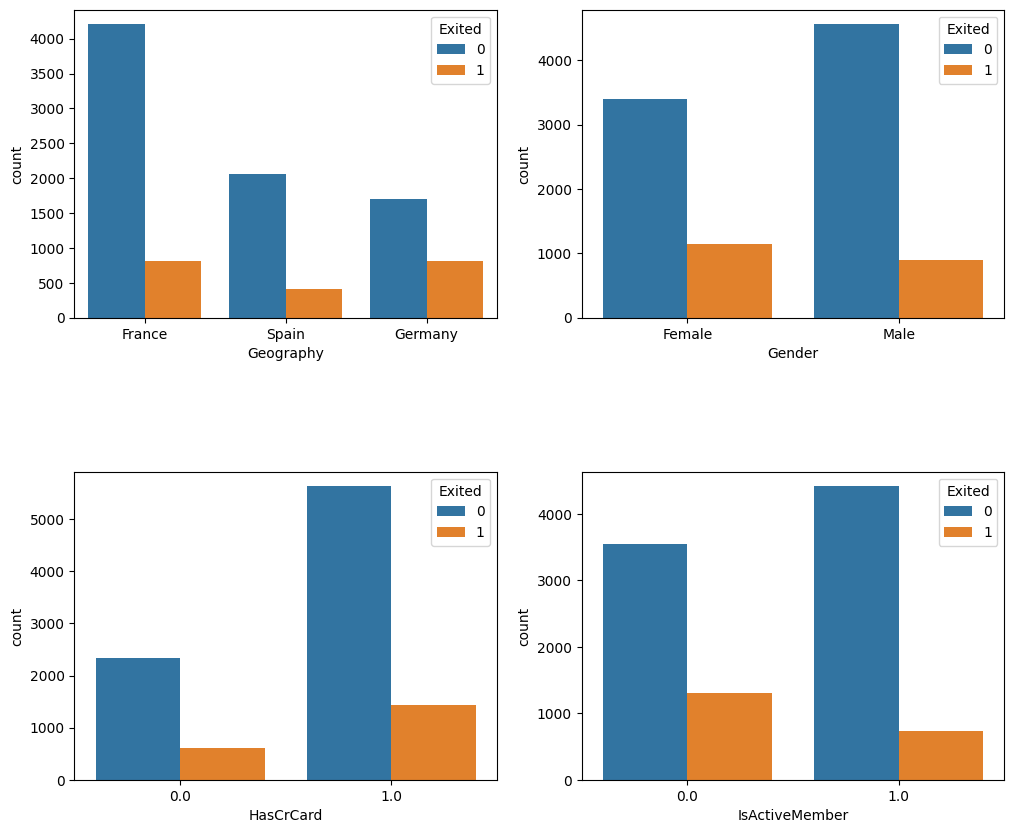

In [8]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
for idx, cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=train,hue='Exited',ax=axes[row,col])

plt.subplots_adjust(hspace=0.5)

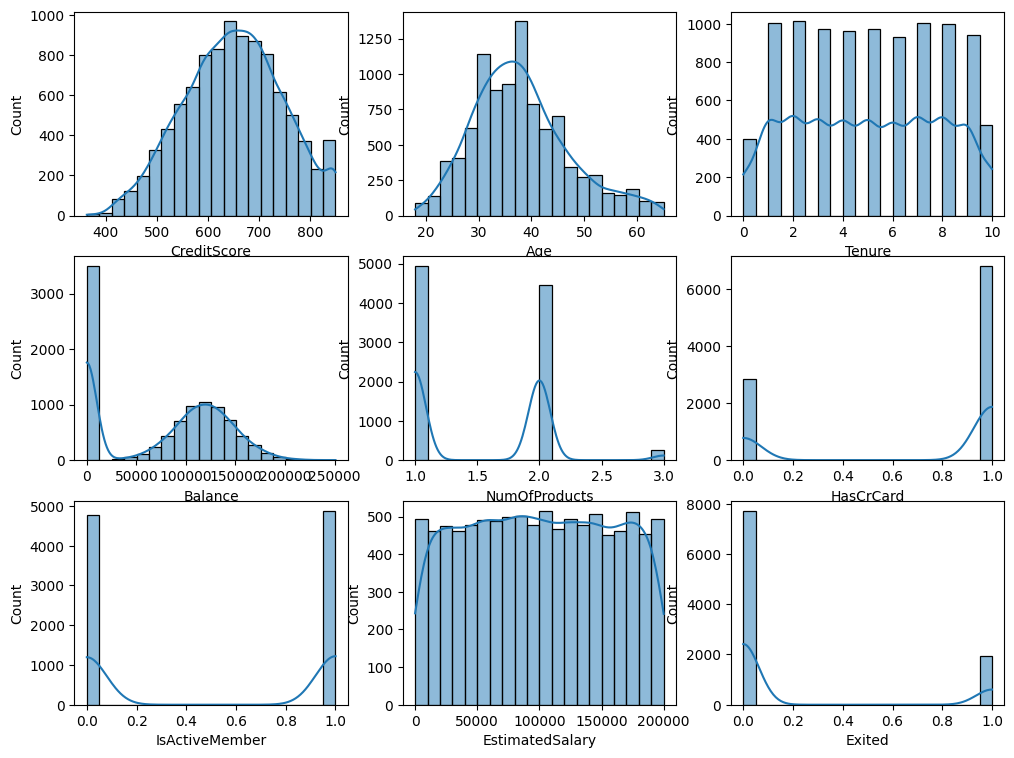

In [50]:
plt.figure(figsize=(12,9))
for i, col in enumerate(numerical_columns):
    plt.subplot(3,3,i+1)
    sns.histplot(data=train, x=col, bins=20, kde=True)

Average age of each group by Gender

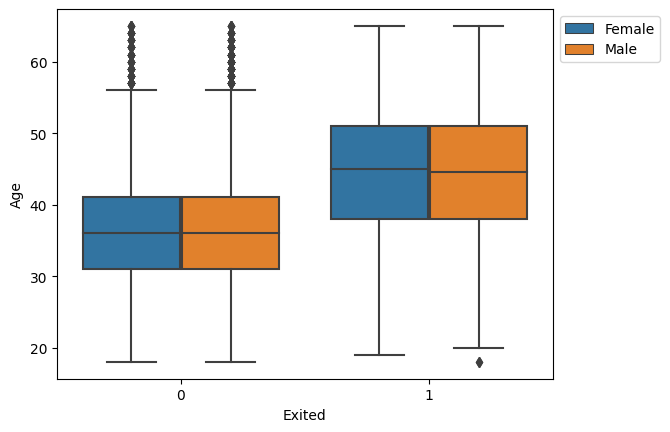

In [57]:
sns.boxplot(data=train, x=train.Exited, y=train.Age, hue='Gender')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Average balance of each group by Gender

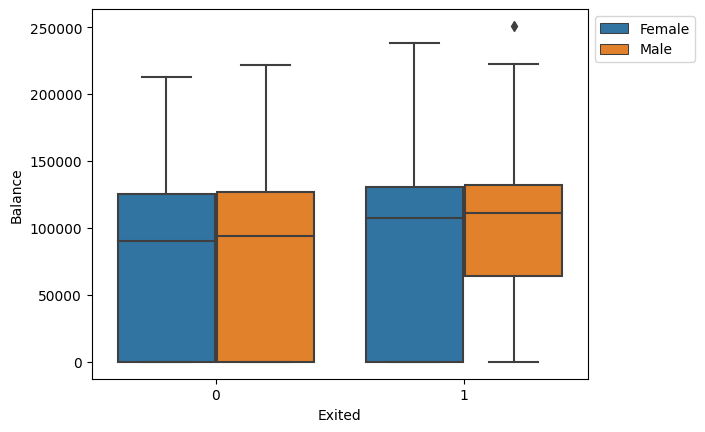

In [58]:
sns.boxplot(data=train, x=train.Exited, y=train.Balance, hue='Gender')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Relation between Age, Balance and Churn

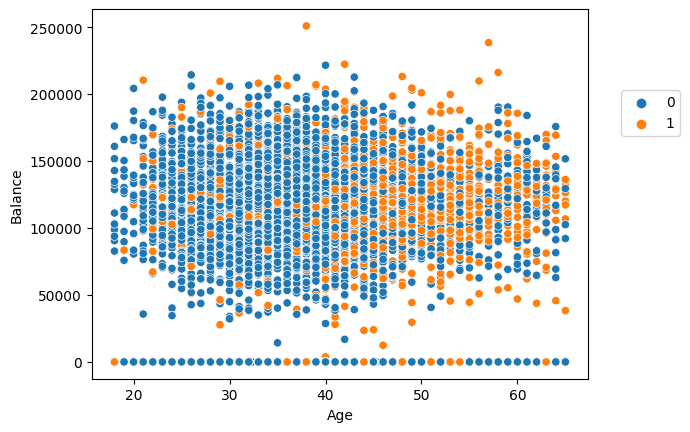

In [60]:
sns.scatterplot(data=train,x=train.Age,y=train.Balance,hue="Exited")
plt.legend(bbox_to_anchor=(1.2,0.8))

# Transforming data and creating model

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

In [62]:
model = RandomForestClassifier(n_estimators=27)

Upsampling data

In [64]:
exited = train[train.Exited==1]
no_exit = train[train.Exited==0]
upsampled_exited = resample(exited, replace=True, n_samples=len(no_exit))
data_model = pd.concat([upsampled_exited, no_exit])

In [65]:
data_model.Exited.value_counts()

Exited
1    7730
0    7730
Name: count, dtype: int64

In [66]:
for col in ['Geography', 'Gender']:
    data_model[col] = label_encoder.fit_transform(data_model[col])

In [67]:
X = data_model.drop(columns=['Exited'])
y = data_model['Exited']

Splitting data, training models and evaluation

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [70]:
model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=27)

In [71]:
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.9995148771021992
0.9427554980595084


In [76]:
y_predicted = model.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print("Accuracy:", accuracy)
# print("Test F1 Score: ",f1_score(y_test,y_predicted))
print("Classification Report:")
print(classification_report(y_test, y_predicted))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.9427554980595084
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1583
           1       0.91      0.98      0.94      1509

    accuracy                           0.94      3092
   macro avg       0.94      0.94      0.94      3092
weighted avg       0.95      0.94      0.94      3092

Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,1437,146,1583
1,31,1478,1509
All,1468,1624,3092
